In [45]:
# set up
import pandas as pd
import numpy as np
import pickle
import time 
import os
import matplotlib.pyplot as plt
from datetime import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
data_folder_path = 'C:\\Users\\goodluck\\Desktop\\DB'
raw_data_path =  "C:\\Users\\goodluck\\Desktop\\DB\\raw_data"
storage_path =  "C:\\Users\\goodluck\\Desktop\\DB\\database_storage"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")

# re-open
with open(DTBS_path, 'rb') as f:  
    DTBS = pickle.load(f)

In [380]:
# helper

def select_industry(DTBS, iid):
    TS = dict()

    for one_iid in iid:
        count = 0
        for code in list(DTBS['A'].keys()):
            if DTBS['B'][code]['cat1'] == one_iid:
                TS[code] = DTBS['A'][code]
                count += 1
        print(one_iid, count)
    
    return TS

def takeSecond(elem):
    return elem[1]


def retrieve_low_nodes(TS, codes, days, index, sel_num):
    dl_rank = []
    for code in codes:
        dl_rank.append((code, TS[code][days[index]]['dl']))
        
        dl_rank.sort(key=takeSecond)    
    low = dl_rank[0:sel_num]
    return [j[0] for j in low]

def win_rt(res):
    print("For each transaction:")
    print("Max profit", max(res))
    print("Max loss", min(res))
    wins = []
    win = 0
    for i in res:
        if i >= 0:
            win += 1
            wins.append(True)
        else:
            wins.append(False)
        
    win_rate = win/len(res)
    print("Rate of wins", win_rate)
    print("Info for each transaction", wins)
    
def select_existing(PTS, dt):
    exist = []
    for code in list(PTS.keys()):
        if not np.isnan(PTS[code][dt]['dp']):
            exist.append(code)
    return exist

def select_condition(PTS, codes, dt, name, low, high):
    satisfy = []
    for code in codes:
        if PTS[code][dt][name] <= high:
            if PTS[code][dt][name] >= low:
                satisfy.append(code)
    return satisfy


def sel_dts(DD, st, ed, tp):
    dts = []
    stdt = datetime.strptime(st, '%Y-%m-%d').date()
    eddt = datetime.strptime(ed, '%Y-%m-%d').date()
    for time in DD[tp]:
        dt = datetime.strptime(time, '%Y-%m-%d').date()
        if dt >= stdt:
            if dt <= eddt:
                dts.append(time)
    return dts

def all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit = []
    sum_dl = 0
    all_codes = []
    res = []
    if sel_ct == 1:
        TS = select_industry(DTBS, ct)
    else:
        TS = DTBS['A']
    for i in range(len(days)):  
#         if sel_dl == 1:
#             curr_dl_codes = retrieve_low_nodes(TS, days, i, sel_num)
#         else:
#             curr_dl_codes = select_existing(TS, days[i])

#         curr_dl_codes = select_existing(TS, days[i])

        if i+1 == len(days):
            curr_dl_codes = select_existing(TS, days[i])

            if sel_cd1 == 1:
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)                
            
        else: 
            ctw = select_existing(TS, days[i])
            cnw = select_existing(TS, days[i+1])
            curr_dl_codes = list(set(ctw).intersection(set(cnw)))
            
                
            if sel_cd1 == 1:
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
                if len(curr_dl_codes) == 0:
                    print("Nothing Satisfies!", sel_nm1)
                    
#             if sel_cd2 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm2, sel_low2, sel_high2)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm2)
                    
#             if sel_cd3 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm3, sel_low3, sel_high3)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm3)
                    
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)
#         print(len(curr_dl_codes))
        all_codes.append(curr_dl_codes)
        if i >= 1:
        
            tw = 0
            lw = 0
            for cd in all_codes[i-1]:
                tw += TS[cd][days[i]]['dp']
        
        
            for cd in all_codes[i-1]:
                lw += TS[cd][days[i-1]]['dp']
        
            re = ((tw - lw)/ lw)
            res.append(re)
            sum_dl += re
        
            profit.append(sum_dl)
    return profit, res
    

def plot_str(days, profit,tick_spacing = 4.5, market = DTBS['C']):
    plt.figure(dpi = 1000)

    fig, ax = plt.subplots(1,1)
    plt.plot(days[1:], profit)
    # ewi
    i_x = [days[1], days[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

    market_gain = (market['zi'][days[-1]]-market['zi'][days[0]])/(market['zi'][days[0]])
    i_y = [0, market_gain]
    plt.plot(i_x, i_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.ylabel('Increase per year/%')
    plt.show()

    print("Final gain", profit[-1])
    print("Market index", market_gain)

def start(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit, res = all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1)
    ap.append(profit)
    aw.append(profit)
    plot_str(days, profit)
    win_rt(res)

f2020 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','mon')
s2020 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','mon')
f2021 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','mon')
s2021 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','mon')
f2022 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','mon')
s2022 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','mon')
a2023 = sel_dts(DTBS['D'],'2023-01-01','2023-3-22','mon')
a2020 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','mon')
a2022 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','mon')
a2021 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','mon')

def leap(ori, gap):
    new = []
    for i in range(len(ori)):
        if i % gap == 0:
            new.append(ori[i])
    return new

leap(f2020,1)


In [108]:
# helper

def select_industry(DTBS, iid):
    TS = dict()

    for one_iid in iid:
        count = 0
        for code in list(DTBS['A'].keys()):
            if DTBS['B'][code]['cat1'] == one_iid:
                TS[code] = DTBS['A'][code]
                count += 1
#         print(one_iid, count)
    
    return TS

def takeSecond(elem):
    return elem[1]


def retrieve_low_nodes(TS, codes, days, index, sel_num):
    dl_rank = []
    for code in codes:
        dl_rank.append((code, TS[code][days[index]]['dl']))
        
        dl_rank.sort(key=takeSecond)    
    low = dl_rank[0:sel_num]
    return [j[0] for j in low]

def win_rt(res):
    print("For each transaction:")
    print("Max profit", max(res))
    print("Max loss", min(res))
    wins = []
    win = 0
    for i in res:
        if i >= 0:
            win += 1
            wins.append(True)
        else:
            wins.append(False)
        
    win_rate = win/len(res)
    print("Rate of wins", win_rate)
    print("Info for each transaction", wins)
    
def select_existing(PTS, dt):
    exist = []
    for code in list(PTS.keys()):
        if not np.isnan(PTS[code][dt]['dp']):
            exist.append(code)
    return exist

def select_condition(PTS, codes, dt, name, low, high):
    satisfy = []
    for code in codes:
        if PTS[code][dt][name] <= high:
            if PTS[code][dt][name] >= low:
                satisfy.append(code)
    return satisfy


def sel_dts(DD, st, ed, tp):
    dts = []
    stdt = datetime.strptime(st, '%Y-%m-%d').date()
    eddt = datetime.strptime(ed, '%Y-%m-%d').date()
    for time in DD[tp]:
        dt = datetime.strptime(time, '%Y-%m-%d').date()
        if dt >= stdt:
            if dt <= eddt:
                dts.append(time)
    return dts

def all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit = []
    sum_dl = 0
    all_codes = []
    res = []
 
    TS = DTBS['A']
    for i in range(len(days)):  
#         if sel_dl == 1:
#             curr_dl_codes = retrieve_low_nodes(TS, days, i, sel_num)
#         else:
#             curr_dl_codes = select_existing(TS, days[i])

#         curr_dl_codes = select_existing(TS, days[i])

        if i+1 == len(days):
            curr_dl_codes = select_existing(TS, days[i])

           
            
        else: 
            ctw = select_existing(TS, days[i])
            cnw = select_existing(TS, days[i+1])
            curr_dl_codes = list(set(ctw).intersection(set(cnw)))
            
        if sel_ct == 1:
            ct_result = []
#             print(days[i])
            for idt in ct:
                
                ITS = select_industry(DTBS, [idt])
                ct_codes = list(ITS.keys())
                ct_curr = list(set(curr_dl_codes).intersection(set(ct_codes)))
                if sel_cd1 == 1:
                    ct_codes = select_condition(ITS, ct_codes, days[i], sel_nm1, sel_low1, sel_high1)
                    if len(curr_dl_codes) == 0:
                        print("Nothing Satisfies!", sel_nm1)
                    

                if sel_dl == 1:
                    ct_codes = retrieve_low_nodes(ITS, ct_codes, days, i, sel_num)
                
#                 print(idt, ct_codes)
                for ocd in ct_codes:
                    ct_result.append(ocd)
            all_codes.append(ct_result)
                    
                

                
        else:
            if sel_cd1 == 1:
                
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
                if len(curr_dl_codes) == 0:
                    print("Nothing Satisfies!", sel_nm1)
                    
#             if sel_cd2 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm2, sel_low2, sel_high2)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm2)
                    
#             if sel_cd3 == 1:
#                 curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm3, sel_low3, sel_high3)
#                 if len(curr_dl_codes) == 0:
#                     print("Nothing Satisfies!", sel_nm3)
                    
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)
        
#         print(len(curr_dl_codes))
            all_codes.append(curr_dl_codes)
        if i >= 1:
        
            tw = 0
            lw = 0
            for cd in all_codes[i-1]:
#                 if i==3:
#                     print(days[3])
#                     print(days[2])
#                     print(cd, TS[cd][days[i]]['dp'])
#                     print(cd, TS[cd][days[i-1]]['dl'])
                tw += TS[cd][days[i]]['dp']
        
        
            for cd in all_codes[i-1]:
                lw += TS[cd][days[i-1]]['dp']
        
            re = ((tw - lw)/ lw)
            res.append(re)

            sum_dl += re
            profit.append(sum_dl)
#     print(all_codes)
#     print(profit)
    return profit, res
    

def plot_str(days, profit,tick_spacing = 4.5, market = DTBS['C']):
    plt.figure(dpi = 1000)

    fig, ax = plt.subplots(1,1)
    plt.plot(days[1:], profit)
    # ewi
    i_x = [days[1], days[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

    market_gain = (market['zi'][days[-1]]-market['zi'][days[0]])/(market['zi'][days[0]])
    i_y = [0, market_gain]
    plt.plot(i_x, i_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.ylabel('Increase per year/%')
    plt.show()

    print("Final gain", profit[-1])
    print("Market index", market_gain)

def start(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit, res = all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1)
    ap.append(profit)
    aw.append(profit)
    plot_str(days, profit)
    win_rt(res)

def plot_str(days, profit,tick_spacing = 4.5, market = DTBS['C']):
    plt.figure(dpi = 1000)

    fig, ax = plt.subplots(1,1)
    plt.plot(days[1:], profit)
    # ewi
    i_x = [days[1], days[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

    market_gain = (market['zi'][days[-1]]-market['zi'][days[0]])/(market['zi'][days[0]])
    i_y = [0, market_gain]
    plt.plot(i_x, i_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.ylabel('Increase per year/%')
    plt.show()

    print("Final gain", profit[-1])
    print("Market index", market_gain)
f2020 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','mon')
s2020 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','mon')
f2021 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','mon')
s2021 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','mon')
f2022 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','mon')
s2022 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','mon')
a2023 = sel_dts(DTBS['D'],'2023-01-01','2023-3-22','mon')
a2020 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','mon')
a2022 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','mon')
a2021 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','mon')

def leap(ori, gap):
    new = []
    for i in range(len(ori)):
        if i % gap == 0:
            new.append(ori[i])
    return new


In [135]:
ap = []
aw = []


<Figure size 6000x4000 with 0 Axes>

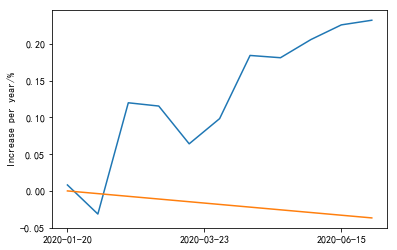

Final gain 0.2319718687571902
Market index -0.03668576901966513
For each transaction:
Max profit 0.15121877741252335
Max loss -0.0513361927508752
Rate of wins 0.6363636363636364
Info for each transaction [True, False, True, False, False, True, True, False, True, True, True]


In [112]:
times = f2020
tt = '2020上半年行业+换手+双低1策略'
idts = ['农林牧渔(2021)', '基础化工(2021)', '美容护理(2021)', '通信(2021)', '非银金融(2021)', '电力设备(2021)', '汽车(2021)', '电子(2021)']
start(DTBS, leap(times, 2), idts, 1, 1, 1, 1, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

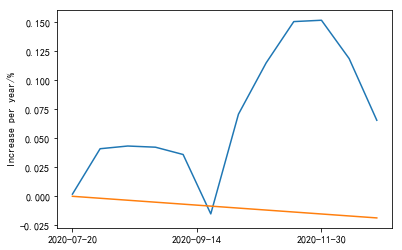

Final gain 0.0655560555316568
Market index -0.018645967595745706
For each transaction:
Max profit 0.08597614425208872
Max loss -0.05321653034178395
Rate of wins 0.5833333333333334
Info for each transaction [True, True, True, False, False, False, True, True, True, True, False, False]


In [117]:
times = s2020
tt = '2020下半年行业+换手+双低1策略'
idts = ['家用电器(2021)', '基础化工(2021)', '建筑材料(2021)', '建筑装饰(2021)', '机械设备(2021)', '商贸零售(2021)', '计算机(2021)', '国防军工(2021)', '钢铁(2021)', '传媒(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 1, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

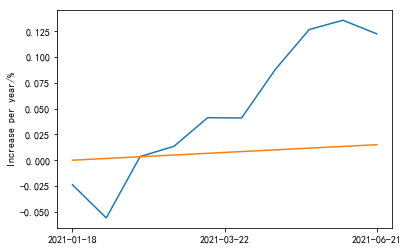

Final gain 0.12233624765861227
Market index 0.015012005248918965
For each transaction:
Max profit 0.059397405269139794
Max loss -0.03213593499019046
Rate of wins 0.6
Info for each transaction [False, False, True, True, True, False, True, True, True, False]


In [121]:
times = f2021
tt = '2021上半年行业+换手+双低1策略'
idts = ['汽车(2021)', '交通运输(2021)', '农林牧渔(2021)', '煤炭(2021)', '有色金属(2021)', '商贸零售(2021)', '机械设备(2021)', '钢铁(2021)', '电力设备(2021)', '基础化工(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 1, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

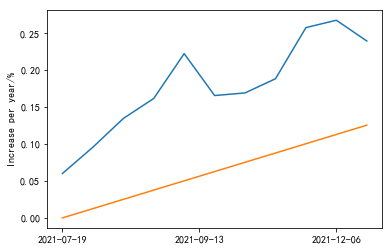

Final gain 0.23936139811214627
Market index 0.12542651022902263
For each transaction:
Max profit 0.0692142256703992
Max loss -0.05666511050635935
Rate of wins 0.8181818181818182
Info for each transaction [True, True, True, True, True, False, True, True, True, True, False]


In [125]:
times = s2021
tt = '2021下半年行业+换手+双低1策略'
idts = ['电力设备(2021)', '有色金属(2021)', '交通运输(2021)', '钢铁(2021)', '通信(2021)', '汽车(2021)', '基础化工(2021)', '轻工制造(2021)', '国防军工(2021)', '医药生物(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 1, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

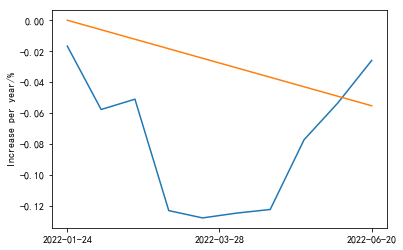

Final gain -0.026027303347905675
Market index -0.05531962600880805
For each transaction:
Max profit 0.04506403320595462
Max loss -0.07206558514791363
Rate of wins 0.6
Info for each transaction [False, False, True, False, False, True, True, True, True, True]


In [129]:
times = f2022
tt = '2022上半年行业+换手+双低1策略'
idts = ['有色金属(2021)', '机械社保(2021)', '基础化工(2021)', '农林牧渔(2021)', '汽车(2021)', '交通运输(2021)', '国防军工(2021)', '医药生物(2021)', '通信(2021)', '电力设备(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 1, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

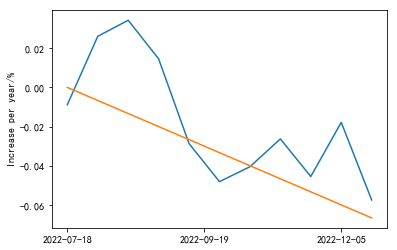

Final gain -0.05727892213452114
Market index -0.0663953989832808
For each transaction:
Max profit 0.03481124159821305
Max loss -0.04310452223744885
Rate of wins 0.45454545454545453
Info for each transaction [False, True, True, False, False, False, True, True, False, True, False]


In [133]:
times = s2022
tt = '2022下半年行业+换手+双低1策略'
idts = ['有色金属(2021)', '农林牧渔(2021)', '汽车(2021)', '电力设备(2021)', '公用事业(2021)', '社会服务(2021)', '食品饮料(2021)', '医药生物(2021)', '轻工制造(2021)', '建筑材料(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 1, 'trt', 2, 10)

<Figure size 6000x4000 with 0 Axes>

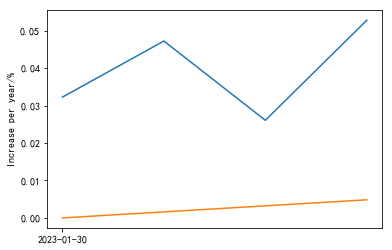

Final gain 0.05277623003786634
Market index 0.004831515304733499
For each transaction:
Max profit 0.03224940259401932
Max loss -0.02116160562820535
Rate of wins 0.75
Info for each transaction [True, True, False, True]


In [137]:
times = a2023
tt = '2023上半年行业+换手+双低1策略'
idts = ['建筑材料(2021)', '建筑装饰(2021)', '国防军工(2021)', '计算机(2021)', '通信(2021)', '食品饮料(2021)', '社会服务(2021)', '纺织服饰(2021)', '交通运输(2021)', '轻工制造(2021)']
start(DTBS, leap(times,2), idts, 1, 1, 1, 1, 'trt', 2, 10)

<Figure size 30000x20000 with 0 Axes>

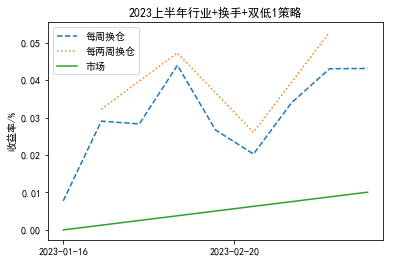

In [138]:
# plot together


from pylab import *
from matplotlib.font_manager import FontProperties  
import matplotlib.pyplot as plt 

font = FontProperties(fname=r"simsun.ttf", size=14)  
matplotlib.rcParams['axes.unicode_minus'] =False
mpl.rcParams['font.sans-serif'] = ['SimHei']

# times = a2023

tick_spacing = 4.5
plt.figure(dpi = 5000)

fig, ax = plt.subplots(1,1)
plt.plot(leap(times, 1)[1:], ap[0],linestyle='dashed', label='每周换仓')

plt.plot(leap(times, 2)[1:], ap[1],linestyle='dotted', label='每两周换仓')

# plt.plot(leap(times, 4)[1:], ap[2],linestyle='dashdot',label='每月换仓')

i_x = [leap(times, 1)[1], leap(times, 1)[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

market_gain = (DTBS['C']['zi'][leap(times, 1)[-1]]-DTBS['C']['zi'][leap(times, 1)[0]])/(DTBS['C']['zi'][leap(times, 1)[0]])
i_y = [0, market_gain]
plt.plot(i_x, i_y, linestyle='solid', label='市场')

plt.legend()

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.ylabel('收益率/%')

plt.title(tt)
plt.savefig(tt)
plt.show()

with open('log.txt','a') as f:
    print(tt, file=f)
    print("市场收益：", market_gain, file=f)
#     print("每周换仓收益：", ap[0][-1], file=f)
#     print("每两周换仓收益：", ap[1][-1], file=f)
#     print("每月换仓收益：", ap[2][-1], file=f)
    print(ap[0][-1], file=f)
    print(ap[1][-1], file=f)
#     print(ap[2][-1], file=f)
#     print(ap[0][-1], ap[1][-1], file=f)
    print("\n", file=f)
    


In [93]:
ap

[[0.021009942459531587,
  0.029508881382897322,
  -0.06388037022415878,
  0.011622239235201365,
  0.07713719804272695,
  0.11759187288414052,
  0.061430684687589956,
  0.047290253979064556,
  0.011527713760965001,
  0.009502644377940425,
  0.02328163523057476,
  0.01409252923051579,
  0.06151354571034094,
  0.05568157605724135,
  0.07491548614497548,
  0.03705177368016369,
  -0.005532057489205329,
  0.03975117944397322,
  0.04515000119759671,
  0.03271253091411851,
  0.05899536612667966,
  0.04932697019016221],
 [0.02090872650243432,
  0.011183730278805926,
  0.1294018239064174,
  0.05833985195946749,
  0.024638515649447558,
  0.023148860849029756,
  0.064273715598468,
  0.054554508211171984,
  0.05405183881572881,
  0.0532616046599234,
  0.07289217845055726],
 [0.01449824335860315,
  0.04196189236885732,
  -0.010355606208762518,
  0.025495349784482757,
  0.016300642727501542]]

In [105]:
DTBS['A']['123019.SZ'][]

{'2017-01-03': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-04': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-05': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-06': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-09': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-10': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-11': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-12': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-13': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-16': {'cp

In [108]:
2 in range(0,10)

True

In [164]:
DTBS['C']['zi']['2023-03-20'] = np.float64(DTBS['C']['zi']['2023-03-20'])
DTBS['C']['zi']['2023-03-21'] = np.float64(DTBS['C']['zi']['2023-03-21'])
DTBS['C']['zi']['2023-03-22'] = np.float64(DTBS['C']['zi']['2023-03-22'])

In [165]:
# save
f_save = open(DTBS_path, 'wb')
pickle.dump(DTBS, f_save)
f_save.close()


In [161]:
type(np.float64(411.2))

numpy.float64

In [97]:
DTBS['A']['123019.SZ']['2020-03-26']

{'cpr': nan,
 'dp': nan,
 'bl': nan,
 'trt': nan,
 'ytm': nan,
 'yl': nan,
 'ia': 0,
 'dl': 999}

In [98]:
DTBS['B']['123019.SZ']

{'ipo': '2019-03-22',
 'cn': '中来转债',
 'dld': '2020-03-25',
 'sc': '300393.SZ',
 'sn': '中来股份',
 'cat1': '电力设备(2021)',
 'cat2': '光伏设备(2021)'}

In [99]:
DTBS['B']['128061.SZ']

{'ipo': '2019-04-24',
 'cn': '启明转债',
 'dld': '2020-03-03',
 'sc': '002439.SZ',
 'sn': '启明星辰',
 'cat1': '计算机(2021)',
 'cat2': '软件开发(2021)'}